##### $\hspace{15pt}$ **Filename: imageRecognitionOnCIFAR.ipynb**
##### $\hspace{1.5pt}$ **Date Created: January 7, 2024**
##### **Date Modified: January 10, 2024**
##### $\rule{10.5in}{1pt}$
##### **Train and test a fully connected neural network to recognize images in a subset of the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The content of this notebook is based on the discussion in sections 7.1 and 7.2 of the book [Deep Learning with Pytorch](https://www.manning.com/books/deep-learning-with-pytorch). Some changes were made in the presentation of the content particularly in the specific example that was created for demonstration purposes.**
##### $\rule{10.5in}{1pt}$

##### Load modules and packages.

In [1]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch

##### Set the seed of Pytorch random number generator.

In [2]:
torch.manual_seed(0)

##### Download datasets from CIFAR-10 train and test sets.

In [3]:
path = "gdrive/MyDrive/Colab Notebooks/011_imageRecognitionOnCIFAR/"
cifar10TrainSet = datasets.CIFAR10(path, train = True, download = True, transform = transforms.ToTensor())
cifar10TestSet = datasets.CIFAR10(path, train = False, download = True, transform = transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:02<00:00, 81323622.83it/s]


Extracting gdrive/MyDrive/Colab Notebooks/011_imageRecognitionOnCIFAR/cifar-10-python.tar.gz to gdrive/MyDrive/Colab Notebooks/011_imageRecognitionOnCIFAR/
Files already downloaded and verified


##### Stack along an extra dimension all the tensors in the train set.

In [4]:
stackedTensors = torch.stack([image for image, label in cifar10TrainSet], dim = 3)

##### Calculate the mean per channel.

In [5]:
channelMeans = stackedTensors.view(3, -1).mean(dim = 1)
channelMeans = tuple(channelMeans.tolist())
channelMeans

(0.4913996458053589, 0.48215845227241516, 0.44653093814849854)

##### Calculate the standard deviation per channel.

In [6]:
channelSDs = stackedTensors.view(3, -1).std(dim = 1)
channelSDs = tuple(channelSDs.tolist())
channelSDs

(0.24703224003314972, 0.24348513782024384, 0.26158785820007324)

##### Normalize the train and test sets.

In [7]:
cifar10TrainSet = datasets.CIFAR10(path, train = True, download = False,
                                   transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(channelMeans, channelSDs)]))
cifar10TestSet = datasets.CIFAR10(path, train = False, download = False,
                                  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(channelMeans, channelSDs)]))

##### Display a sample of cat images.

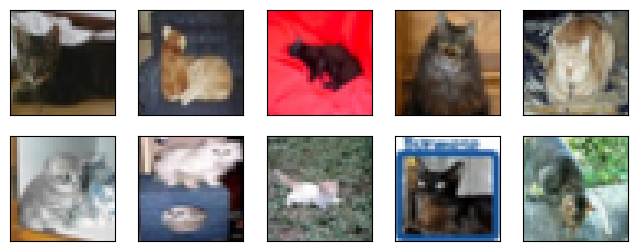

In [8]:
fig = plt.figure(figsize = (8, 3))

catImages = [image for image, label in datasets.CIFAR10(path, train = True, download = False) if label == 3]
for i in range(10):

    ax = fig.add_subplot(2, 5, 1 + i, xticks = [], yticks = [])
    plt.imshow(catImages[i])

plt.show()

##### Display a sample of dog images.

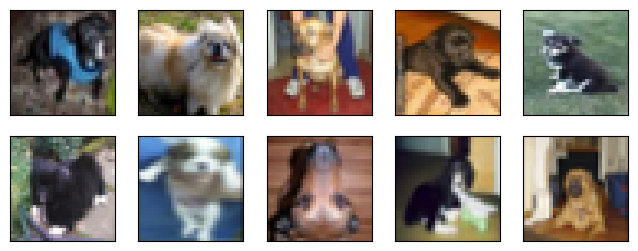

In [9]:
fig = plt.figure(figsize = (8, 3))

dogImages = [image for image, label in datasets.CIFAR10(path, train = True, download = False) if label == 5]
for i in range(10):

    ax = fig.add_subplot(2, 5, 1 + i, xticks = [], yticks = [])
    plt.imshow(dogImages[i])

plt.show()

##### Filter the train and test sets to get only the cat and dog images.

In [10]:
labelMap = {3: 0, 5: 1}
cifar2TrainSet = [(image, labelMap[label]) for image, label in cifar10TrainSet if label in [3, 5]]
cifar2TestSet = [(image, labelMap[label]) for image, label in cifar10TestSet if label in [3, 5]]

##### Define a function that will be used to train and test an image recognition model.

In [11]:
def train(nEpochs, optimizer, model, loss, displayEpochs = True):
    "Train and test an image recognition model."

    trainLossList = []
    testLossList = []
    for epoch in range(1, nEpochs + 1):

        for image, label in cifar2TrainSet:

            output = model(image.view(-1).unsqueeze(0))
            trainL = loss(output, torch.tensor([label]))

            optimizer.zero_grad()
            trainL.backward()
            optimizer.step()

        with torch.no_grad():

             for image, label in cifar2TestSet:

                 output = model(image.view(-1).unsqueeze(0))
                 testL = loss(output, torch.tensor([label]))
                 assert testL.requires_grad == False

        if displayEpochs:

           if epoch <= 3 or epoch >= nEpochs - 2:

              print('Epoch %d:' % epoch)
              print('    Training Loss = %f' % trainL)
              print('        Test Loss = %f' % testL)
              print('')

           if epoch == 4:
              print('...\n...\n...\n')

        trainLossList.append(float(trainL))
        testLossList.append(float(testL))

    return trainLossList, testLossList

##### Run the function using a neural network with an input layer of 3,072 neurons, a hidden layer of 512 neurons with a `Tanh` activation function, and an output layer of 2 neurons with a `LogSoftmax` activation function.

In [12]:
nEpochs = 100
model = torch.nn.Sequential(torch.nn.Linear(3072, 512),
                            torch.nn.Tanh(),
                            torch.nn.Linear(512, 2),
                            torch.nn.LogSoftmax(dim = 1))
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss = torch.nn.NLLLoss()
trainLossList, testLossList = train(nEpochs = nEpochs, optimizer = optimizer, model = model, loss = loss)

Epoch 1:
    Training Loss = 2.827408
        Test Loss = 6.300457

Epoch 2:
    Training Loss = 1.040253
        Test Loss = 3.921537

Epoch 3:
    Training Loss = 2.896033
        Test Loss = 13.167205

...
...
...

Epoch 98:
    Training Loss = 0.003699
        Test Loss = 0.348899

Epoch 99:
    Training Loss = 0.015740
        Test Loss = 5.101172

Epoch 100:
    Training Loss = 0.000044
        Test Loss = 2.517753



##### Display how the values of the loss function change throughout the 100 epochs in the training set.

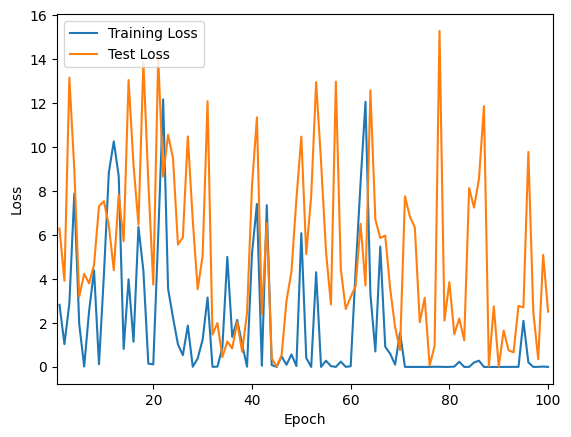

In [13]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.plot(range(1, len(trainLossList) + 1), trainLossList)
plt.plot(range(1, len(testLossList) + 1), testLossList)
plt.xlim([0.5, nEpochs + 1])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Test Loss"], loc ="upper left")
plt.show()

##### List the number of parameters the model has in its layers.

In [14]:
numelList = [p.numel() for p in model.parameters() if p.requires_grad == True]
numelList

[1572864, 512, 1024, 2]

##### Count the total number of parameters the model has.

In [15]:
sum(numelList)

1574402

##### The following function is a revision, which is called version 2 here, of the function that trains and tests an image recognition model. It uses the *DataLoader* class from the `torch.utils.data` module. The class will be used to shuffle and organize data in minibatches for forward and backward propagation in the training process as well as for estimating the accuracy of the model.

In [16]:
def train_v2(nEpochs, optimizer, model, loss, displayEpochs = True):
    "Train and test an image recognition model and estimate its accuracy."

    trainLoader = torch.utils.data.DataLoader(cifar2TrainSet, batch_size = 64, shuffle = True)
    testLoader = torch.utils.data.DataLoader(cifar2TestSet, batch_size = 64, shuffle = True)

    trainLossList = []
    testLossList = []
    for epoch in range(1, nEpochs + 1):

        for images, labels in trainLoader:

            batchSize = images.shape[0]
            outputs = model(images.view(batchSize, -1))
            trainL = loss(outputs, labels)

            optimizer.zero_grad()
            trainL.backward()
            optimizer.step()

        with torch.no_grad():

             for images, labels in testLoader:

                 batchSize = images.shape[0]
                 outputs = model(images.view(batchSize, -1))
                 testL = loss(outputs, labels)
                 assert testL.requires_grad == False

        if displayEpochs:

           if epoch <= 3 or epoch >= nEpochs - 2:

              print('Epoch %d:' % epoch)
              print('    Training Loss = %f' % trainL)
              print('        Test Loss = %f' % testL)
              print('')

           if epoch == 4:
              print('...\n...\n...\n')

        trainLossList.append(float(trainL))
        testLossList.append(float(testL))

    trainLoader = torch.utils.data.DataLoader(cifar2TrainSet, batch_size = 64, shuffle = False)
    testLoader = torch.utils.data.DataLoader(cifar2TestSet, batch_size = 64, shuffle = False)

    with torch.no_grad():

        trainCorrect = 0
        trainTotal = 0
        for images, labels in trainLoader:

            batchSize = images.shape[0]
            outputs = model(images.view(batchSize, -1))
            scores, predictions = torch.max(outputs, dim=1)
            trainCorrect += int((predictions == labels).sum())
            trainTotal += labels.shape[0]

        testCorrect = 0
        testTotal = 0
        for images, labels in testLoader:

            batchSize = images.shape[0]
            outputs = model(images.view(batchSize, -1))
            scores, predictions = torch.max(outputs, dim=1)
            testCorrect += int((predictions == labels).sum())
            testTotal += labels.shape[0]

    print("Training Accuracy: %f" % (trainCorrect/trainTotal))
    print("    Test Accuracy: %f" % (testCorrect/testTotal))

    return trainLossList, testLossList

##### Run the revised function using a neural network with the same architecture as before.

In [17]:
nEpochs = 100
model = torch.nn.Sequential(torch.nn.Linear(3072, 512),
                            torch.nn.Tanh(),
                            torch.nn.Linear(512, 2),
                            torch.nn.LogSoftmax(dim = 1))
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss = torch.nn.NLLLoss()
trainLossList, testLossList = train_v2(nEpochs = nEpochs, optimizer = optimizer, model = model, loss = loss)

Epoch 1:
    Training Loss = 0.564146
        Test Loss = 0.567931

Epoch 2:
    Training Loss = 0.692692
        Test Loss = 0.629217

Epoch 3:
    Training Loss = 0.589004
        Test Loss = 0.584684

...
...
...

Epoch 98:
    Training Loss = 0.024391
        Test Loss = 1.705343

Epoch 99:
    Training Loss = 0.010411
        Test Loss = 0.809070

Epoch 100:
    Training Loss = 0.016697
        Test Loss = 0.854302

Training Accuracy: 0.999900
    Test Accuracy: 0.627500


##### Display how the values of the loss function change throughout the 100 epochs in the training and test sets.

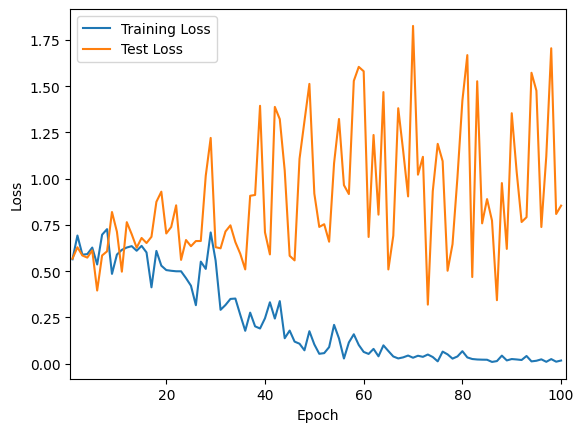

In [18]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.plot(range(1, len(trainLossList) + 1), trainLossList)
plt.plot(range(1, len(testLossList) + 1), testLossList)
plt.xlim([0.5, nEpochs + 1])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Test Loss"], loc ="upper left")
plt.show()

##### Run the revised function using a neural network with an input layer of 3,072 neurons, three hidden layers of 1,024, 512, and 128 neurons respectively each with a `Tanh` activation function, and an output layer of 2 neurons with a `LogSoftmax` activation function.

In [19]:
torch.manual_seed(0)

nEpochs = 100
model = torch.nn.Sequential(torch.nn.Linear(3072, 1024),
                            torch.nn.Tanh(),
                            torch.nn.Linear(1024, 512),
                            torch.nn.Tanh(),
                            torch.nn.Linear(512, 128),
                            torch.nn.Tanh(),
                            torch.nn.Linear(128, 2),
                            torch.nn.LogSoftmax(dim=1))
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss = torch.nn.NLLLoss()
trainLossList, testLossList = train_v2(nEpochs = nEpochs, optimizer = optimizer, model = model, loss = loss)

Epoch 1:
    Training Loss = 0.606496
        Test Loss = 0.733571

Epoch 2:
    Training Loss = 0.589028
        Test Loss = 0.662566

Epoch 3:
    Training Loss = 0.553746
        Test Loss = 0.690032

...
...
...

Epoch 98:
    Training Loss = 0.000164
        Test Loss = 2.049562

Epoch 99:
    Training Loss = 0.000425
        Test Loss = 1.748960

Epoch 100:
    Training Loss = 0.000435
        Test Loss = 3.456338

Training Accuracy: 1.000000
    Test Accuracy: 0.615500


##### List the number of parameters the model has in its layers.

In [20]:
numelList = [p.numel() for p in model.parameters() if p.requires_grad == True]
numelList

[3145728, 1024, 524288, 512, 65536, 128, 256, 2]

##### Count the total number of parameters the model has.

In [21]:
sum(numelList)

3737474

##### Display how the values of the loss function change throughout the 100 epochs in the training and test sets.

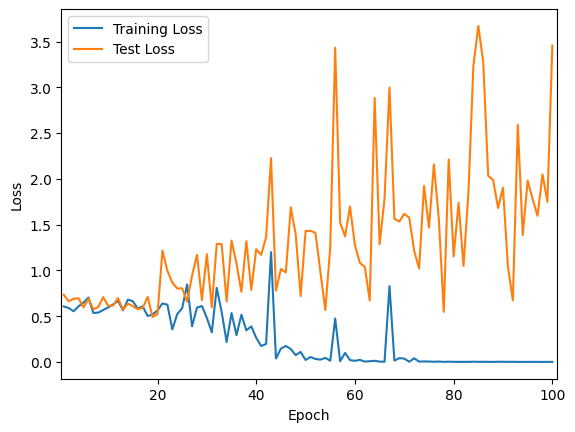

In [22]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.plot(range(1, len(trainLossList) + 1), trainLossList)
plt.plot(range(1, len(testLossList) + 1), testLossList)
plt.xlim([0.5, nEpochs + 1])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Test Loss"], loc ="upper left")
plt.show()

##### Run the revised function using a neural network obtained by dropping the `LogSoftmax` activation function from the previous neural network and replacing the negative log-likelihood function with the cross-entropy loss function.

In [23]:
torch.manual_seed(0)

nEpochs = 100
model = torch.nn.Sequential(torch.nn.Linear(3072, 1024),
                            torch.nn.Tanh(),
                            torch.nn.Linear(1024, 512),
                            torch.nn.Tanh(),
                            torch.nn.Linear(512, 128),
                            torch.nn.Tanh(),
                            torch.nn.Linear(128, 2))
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss = torch.nn.CrossEntropyLoss()
trainLossList, testLossList = train_v2(nEpochs = nEpochs, optimizer = optimizer, model = model, loss = loss)

Epoch 1:
    Training Loss = 0.606496
        Test Loss = 0.733571

Epoch 2:
    Training Loss = 0.589028
        Test Loss = 0.662566

Epoch 3:
    Training Loss = 0.553746
        Test Loss = 0.690032

...
...
...

Epoch 98:
    Training Loss = 0.000164
        Test Loss = 2.049562

Epoch 99:
    Training Loss = 0.000425
        Test Loss = 1.748960

Epoch 100:
    Training Loss = 0.000435
        Test Loss = 3.456338

Training Accuracy: 1.000000
    Test Accuracy: 0.615500


##### Note: Using the `LogSoftmax` activation function at the last layer of the neural network and the negative log-likelihood function as the loss function is equivalent to dropping the `LogSoftmax` activation function from the last layer and using the cross-entropy loss function.